## Multivariable linear regression
### Create the data

In [2]:
# create the data set
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import theano
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
plt.style.use('seaborn-darkgrid')

num_features = 2
data_points = 1000
beta_set = 2.*np.random.normal(size=num_features)
alpha_set = np.random.normal(size=1)

X = np.random.normal(size=(data_points, num_features))
y = alpha_set + np.sum(beta_set*X, axis=1) + np.random.normal(size=(data_points))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Plot the data set

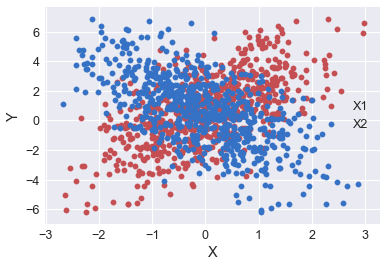

In [3]:
plt.scatter(X_train[:,0], y_train, c='r', label='X1')
plt.scatter(X_train[:,1], y_train, c='b', label='X2')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

### Create the pymc3 model 

In [4]:
lin_reg_model = pm.Model()  #instantiate the pymc3 model object

#Create a shared theano variable. This allows the model to be created using the X_train/y_train data 
# and then test with the X_test/y_test data
model_input = theano.shared(X_train)
model_output = theano.shared(y_train)

with lin_reg_model:
    alpha = pm.Normal('alpha', mu=0, sd=1, shape= (1)) # create random variable alpha of shape 1
    beta = pm.Normal('betas', mu=0, sd=1, shape=(1,num_features)) # create random variable beta of shape 1,num_features
    
    s = pm.HalfNormal('s', sd=1)  # create distribution to describe noise in the data
    
    data_est = alpha + theano.tensor.dot(beta, model_input.T)  # Expected value of outcome
    
    y = pm.Normal('y', mu=data_est, sd=s, observed=y_train)  # Likelihood (sampling distribution) of observations

### Train the model

In [5]:
with lin_reg_model:
    step = pm.NUTS()
    nuts_trace = pm.sample(2000, step, njobs=1)

Sequential sampling (2 chains in 1 job)
NUTS: [s, betas, alpha]
100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:02<00:00, 836.41it/s]


### traceplot and summary statistics

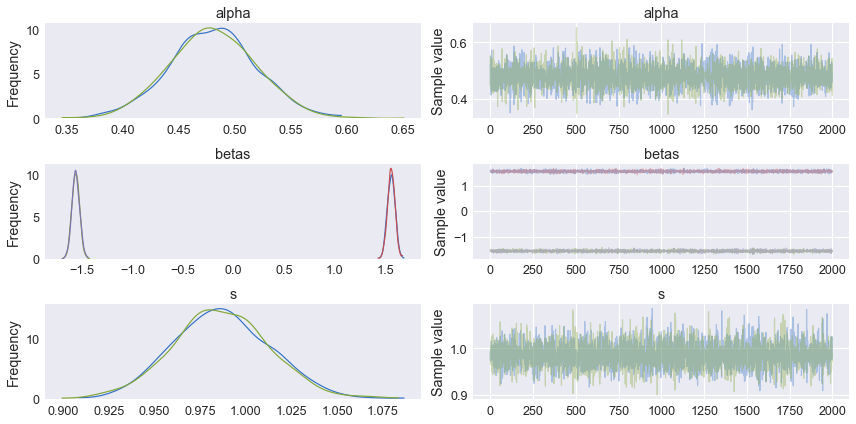

In [6]:
plt.style.use('seaborn-darkgrid')
pm.traceplot(nuts_trace)
plt.show()

In [7]:
pm.summary(nuts_trace[1000:])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha__0,0.480106,0.037595,0.000774,0.405709,0.550487,2975.210769,1.001104
betas__0_0,1.557257,0.036890,0.000658,1.487401,1.628156,3147.314093,0.999515
betas__0_1,-1.562830,0.038143,0.000744,-1.634971,-1.484338,2849.492200,0.999755
s,0.986880,0.027428,0.000468,0.930528,1.038020,3049.781251,0.999667


### Test the trained model on the test data

In [8]:
# set the shared values to the test data
model_input.set_value(X_test)
model_output.set_value(y_test)

#create a posterior predictive check (ppc) to sample the space of test x values
ppc = pm.sample_ppc(
        nuts_trace[1000:], # specify the trace and exclude the first 1000 samples 
        model=lin_reg_model, # specify the trained model
        samples=1000) #for each point in X_test, create 1000 samples

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1683.52it/s]


### Plot the y_test vs y_predict and calculate r**2

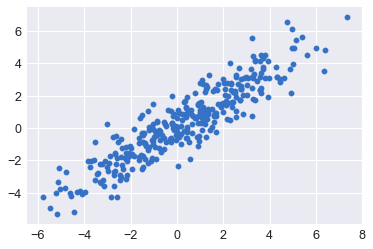

0.835496545799272

In [9]:
pred = ppc['y'].mean(axis=0)  # take the mean value of the 1000 samples at each X_test value 
plt.scatter(y_test, pred)
plt.show()
r2_score(y_test,*pred)